In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn import preprocessing, svm
from scipy.fftpack import fft, rfft
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
import scipy.fftpack
from sklearn import tree
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
import pickle

In [2]:
#load Insulin and CGM Data
insulin_df = pd.read_csv('InsulinData.csv', parse_dates=[['Date','Time']],low_memory=False).iloc[::-1]
cgm_df = pd.read_csv('CGMData.csv', parse_dates=[['Date','Time']],low_memory=False).iloc[::-1]

insulin_df2 = pd.read_csv('Insulin_patient2.csv', parse_dates=[['Date','Time']],low_memory=False).iloc[::-1]
cgm_df2 = pd.read_csv('CGM_patient2.csv', parse_dates=[['Date','Time']],low_memory=False).iloc[::-1]

# cgm_df

In [3]:
insulin_df = insulin_df[['Date_Time','BWZ Carb Input (grams)']]
insulin_df2 = insulin_df2[['Date_Time','BWZ Carb Input (grams)']]

In [4]:
#filter NaNs and Zeros
insulin_Meal_df= insulin_df[insulin_df['BWZ Carb Input (grams)'].notnull() & insulin_df['BWZ Carb Input (grams)'] != 0]
insulin_Meal_df2= insulin_df2[insulin_df2['BWZ Carb Input (grams)'].notnull() & insulin_df2['BWZ Carb Input (grams)'] != 0]

In [5]:
# insulin_Meal_df =insulin_Meal_df['Date_Time','BWZ Carb Input (grams)','Time_dif1','Time_dif2']

In [6]:
#mealstartdates from insulin csv
# value = insulin_Meal_df['Date_Time'].diff(periods=-1)/np.timedelta64(1,'h')
# value
# insulin_Meal_df.loc[:, 'Time_dif1'] = value
# insulin_Meal_df.loc[:,'Time_dif2'] = insulin_Meal_df['Date_Time'].diff(periods=1)/np.timedelta64(1,'h')
# insulin_Meal_df2.loc[:,'Time_dif1'] = insulin_Meal_df2['Date_Time'].diff(periods=-1)/np.timedelta64(1,'h')
# insulin_Meal_df2.loc[:,'Time_dif2'] = insulin_Meal_df2['Date_Time'].diff(periods=1)/np.timedelta64(1,'h')

insulin_Meal_df.loc[:, 'Time_dif1'] = insulin_Meal_df['Date_Time'].diff(periods=-1)/np.timedelta64(1,'h')
insulin_Meal_df.loc[:,'Time_dif2'] = insulin_Meal_df['Date_Time'].diff(periods=1)/np.timedelta64(1,'h')
insulin_Meal_df2.loc[:,'Time_dif1'] = insulin_Meal_df2['Date_Time'].diff(periods=-1)/np.timedelta64(1,'h')
insulin_Meal_df2.loc[:,'Time_dif2'] = insulin_Meal_df2['Date_Time'].diff(periods=1)/np.timedelta64(1,'h')

C:\Users\wayne\anaconda3\envs\py36_cse572\lib\site-packages\pandas\core\indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\wayne\anaconda3\envs\py36_cse572\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [7]:
filt=((insulin_Meal_df['Time_dif1']<-2) | (insulin_Meal_df['Time_dif2'].iloc[-1:]>2))
filt2=((insulin_Meal_df2['Time_dif1']<-2) | (insulin_Meal_df2['Time_dif2'].iloc[-1:]>2))
insulin_Meal_df = insulin_Meal_df.loc[filt]
insulin_Meal_df2 = insulin_Meal_df2.loc[filt2]

In [8]:
#CGM meal datetime
CGM_Meal_Date_Time = []

for datetime in insulin_Meal_df['Date_Time']:
    CGM_Meal_Datetime = cgm_df.loc[cgm_df['Date_Time']>=datetime]['Date_Time'].min()
    if CGM_Meal_Datetime >= cgm_df['Date_Time'].min() + pd.to_timedelta(30, unit='m') and CGM_Meal_Datetime <= cgm_df['Date_Time'].max() - pd.to_timedelta(120, unit='m'):
        CGM_Meal_Date_Time.append(CGM_Meal_Datetime)

# CGM_Meal_Date_Time

In [9]:
CGM_Meal_Date_Time2 = []

for datetime in insulin_Meal_df2['Date_Time']:
    CGM_Meal_Datetime2 = cgm_df2.loc[cgm_df2['Date_Time']>=datetime]['Date_Time'].min()
    if CGM_Meal_Datetime2 >= cgm_df2['Date_Time'].min() + pd.to_timedelta(30, unit='m') and CGM_Meal_Datetime2 <= cgm_df2['Date_Time'].max() - pd.to_timedelta(120, unit='m'):
        CGM_Meal_Date_Time2.append(CGM_Meal_Datetime2)

# CGM_Meal_Date_Time

In [10]:
# CGM_Meal_df = cgm_df[cgm_df['Date_Time'].isin(CGM_Meal_Date_Time)][['Date_Time','Sensor Glucose (mg/dL)']]
# CGM_Meal_df

In [11]:
#CGM noMeal datetime
CGM_No_Meal_Date_Time = []
for i, CGM_Meal_Datetime in enumerate(CGM_Meal_Date_Time[:-1]):
#     print(i, CGM_Meal_Datetime)
    No_Meal_Starttime = CGM_Meal_Datetime + pd.to_timedelta(120, unit='m')
    while No_Meal_Starttime < CGM_Meal_Date_Time[i+1]:
#     while No_Meal_Starttime < CGM_Meal_Date_Time[i+1]-pd.to_timedelta(30, unit='m'):
        CGM_No_Meal_Datetime = cgm_df.loc[cgm_df['Date_Time'] >= No_Meal_Starttime]['Date_Time'].min()
        CGM_No_Meal_Date_Time.append(CGM_No_Meal_Datetime)
        No_Meal_Starttime += pd.to_timedelta(120, unit='m')
# CGM_No_Meal_Date_Time   

In [12]:
CGM_No_Meal_Date_Time2 = []
for i, CGM_Meal_Datetime2 in enumerate(CGM_Meal_Date_Time2[:-1]):
#     print(i, CGM_Meal_Datetime)
    No_Meal_Starttime2 = CGM_Meal_Datetime2 + pd.to_timedelta(120, unit='m')
    while No_Meal_Starttime2 < CGM_Meal_Date_Time2[i+1]:
#     while No_Meal_Starttime < CGM_Meal_Date_Time[i+1]-pd.to_timedelta(30, unit='m'):
        CGM_No_Meal_Datetime2 = cgm_df2.loc[cgm_df2['Date_Time'] >= No_Meal_Starttime2]['Date_Time'].min()
        CGM_No_Meal_Date_Time2.append(CGM_No_Meal_Datetime2)
        No_Meal_Starttime2 += pd.to_timedelta(120, unit='m')
# CGM_No_Meal_Date_Time 

In [13]:
mealDataMatrix = []
for mealDateTime in CGM_Meal_Date_Time:
    idx = cgm_df[cgm_df['Date_Time'] == mealDateTime]['Sensor Glucose (mg/dL)'].index[0]
    mealDataMatrix.append(list(cgm_df['Sensor Glucose (mg/dL)'].iloc[cgm_df.shape[0]-1-idx-6:cgm_df.shape[0]-1-idx+24].values))
# mealDataMatrix

In [14]:
mealDataMatrix2 = []
for mealDateTime2 in CGM_Meal_Date_Time2:
    idx = cgm_df2[cgm_df2['Date_Time'] == mealDateTime2]['Sensor Glucose (mg/dL)'].index[0]
    mealDataMatrix2.append(list(cgm_df2['Sensor Glucose (mg/dL)'].iloc[cgm_df2.shape[0]-1-idx-6:cgm_df2.shape[0]-1-idx+24].values))
# mealDataMatrix

In [15]:
no_mealDataMatrix = []
for no_mealDateTime in CGM_No_Meal_Date_Time:
    idx = cgm_df[cgm_df['Date_Time'] == no_mealDateTime]['Sensor Glucose (mg/dL)'].index[0]
    no_mealDataMatrix.append(list(cgm_df['Sensor Glucose (mg/dL)'].iloc[cgm_df.shape[0]-1-idx:cgm_df.shape[0]-1-idx+24].values))
# no_mealDataMatrix   

In [16]:
no_mealDataMatrix2 = []
for no_mealDateTime2 in CGM_No_Meal_Date_Time2:
    idx = cgm_df2[cgm_df2['Date_Time'] == no_mealDateTime2]['Sensor Glucose (mg/dL)'].index[0]
    no_mealDataMatrix2.append(list(cgm_df2['Sensor Glucose (mg/dL)'].iloc[cgm_df2.shape[0]-1-idx:cgm_df2.shape[0]-1-idx+24].values))
# no_mealDataMatrix2   

In [17]:
mealDate_dict = {}
for datetime, g_value in zip(CGM_Meal_Date_Time,mealDataMatrix):
    mealDate_dict[datetime] = g_value
# print(mealDate_dict)

In [18]:
mealDate_dict2 = {}
for datetime2, g_value2 in zip(CGM_Meal_Date_Time2,mealDataMatrix2):
    mealDate_dict2[datetime2] = g_value2
# print(mealDate_dict)

In [19]:
no_mealDate_dict = {}
for datetime, g_value in zip(CGM_No_Meal_Date_Time,no_mealDataMatrix):
    no_mealDate_dict[datetime] = g_value
# print(no_mealDate_dict)

In [20]:
no_mealDate_dict2 = {}
for datetime2, g_value2 in zip(CGM_No_Meal_Date_Time2,no_mealDataMatrix2):
    no_mealDate_dict2[datetime2] = g_value2
print(no_mealDate_dict2)

{Timestamp('2017-09-05 15:16:21'): [177.0, 175.0, 175.0, 175.0, 170.0, 161.0, 146.0, 134.0, 148.0, 154.0, 147.0, 144.0, 142.0, 137.0, 127.0, 119.0, 108.0, 100.0, 92.0, 94.0, 102.0, 102.0, 99.0, 97.0], Timestamp('2017-09-05 17:16:23'): [93.0, 88.0, 83.0, 76.0, 68.0, 67.0, 69.0, 73.0, 80.0, 97.0, 112.0, 126.0, 130.0, 137.0, 140.0, 135.0, 134.0, 132.0, 128.0, 125.0, 126.0, 127.0, 131.0, 132.0], Timestamp('2017-09-05 19:16:23'): [130.0, 128.0, 127.0, 128.0, 129.0, 126.0, 122.0, 120.0, 118.0, 121.0, 127.0, 134.0, 145.0, 156.0, 162.0, 170.0, 180.0, 191.0, 201.0, 212.0, 219.0, 223.0, 227.0, 229.0], Timestamp('2017-09-05 21:36:25'): [207.0, 205.0, 191.0, 181.0, 174.0, 172.0, 173.0, 175.0, 178.0, 183.0, 190.0, 193.0, 189.0, 180.0, 167.0, 164.0, 168.0, 174.0, 178.0, 178.0, 173.0, 164.0, 153.0, 147.0], Timestamp('2017-09-05 23:36:25'): [142.0, 140.0, 137.0, 133.0, 129.0, 128.0, 124.0, 116.0, 106.0, 101.0, 101.0, 105.0, 110.0, 112.0, 107.0, 96.0, 86.0, nan, nan, nan, nan, nan, 110.0, 129.0], Times

In [21]:
mealDataMatrix_df = pd.DataFrame.from_dict(mealDate_dict, orient='index')
mealDataMatrix_df = mealDataMatrix_df.dropna()
mealDataMatrix_df

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
2017-07-26 12:49:00,304.0,292.0,281.0,268.0,259.0,255.0,248.0,241.0,231.0,220.0,...,270.0,277.0,274.0,269.0,267.0,267.0,274.0,284.0,283.0,278.0
2017-07-26 19:19:01,40.0,40.0,40.0,40.0,60.0,71.0,83.0,87.0,100.0,112.0,...,67.0,71.0,75.0,74.0,72.0,70.0,67.0,74.0,77.0,81.0
2017-07-27 05:49:05,212.0,210.0,204.0,200.0,199.0,201.0,201.0,194.0,188.0,183.0,...,210.0,213.0,212.0,216.0,213.0,210.0,210.0,209.0,210.0,209.0
2017-07-27 09:24:05,145.0,141.0,137.0,133.0,129.0,124.0,125.0,122.0,123.0,130.0,...,200.0,196.0,189.0,183.0,179.0,177.0,173.0,165.0,153.0,152.0
2017-07-27 13:59:06,40.0,40.0,46.0,53.0,57.0,57.0,55.0,58.0,70.0,77.0,...,132.0,140.0,147.0,157.0,172.0,175.0,183.0,191.0,198.0,200.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-02-10 19:50:30,61.0,59.0,59.0,60.0,65.0,70.0,82.0,100.0,126.0,133.0,...,146.0,153.0,158.0,162.0,169.0,163.0,155.0,136.0,114.0,106.0
2018-02-11 10:05:33,57.0,58.0,62.0,74.0,104.0,110.0,126.0,133.0,135.0,141.0,...,168.0,174.0,207.0,209.0,206.0,197.0,185.0,191.0,197.0,202.0
2018-02-11 12:45:34,209.0,219.0,221.0,221.0,216.0,217.0,215.0,211.0,201.0,200.0,...,180.0,184.0,180.0,190.0,196.0,203.0,206.0,212.0,215.0,208.0
2018-02-11 20:37:22,106.0,107.0,100.0,104.0,123.0,132.0,129.0,127.0,120.0,132.0,...,169.0,176.0,173.0,166.0,162.0,189.0,201.0,200.0,194.0,177.0


In [22]:
mealDataMatrix_df2 = pd.DataFrame.from_dict(mealDate_dict2, orient='index')
mealDataMatrix_df2 = mealDataMatrix_df2.dropna()
mealDataMatrix_df2

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
2017-09-05 13:16:21,238.0,242.0,240.0,232.0,229.0,228.0,226.0,225.0,224.0,221.0,...,188.0,186.0,180.0,169.0,160.0,163.0,166.0,172.0,180.0,180.0
2017-09-05 19:36:23,131.0,132.0,130.0,128.0,127.0,128.0,129.0,126.0,122.0,120.0,...,201.0,212.0,219.0,223.0,227.0,229.0,226.0,223.0,217.0,204.0
2017-09-06 08:51:26,165.0,163.0,160.0,157.0,161.0,177.0,185.0,187.0,192.0,190.0,...,140.0,150.0,156.0,157.0,156.0,153.0,150.0,148.0,148.0,148.0
2017-09-06 13:26:28,103.0,108.0,117.0,123.0,128.0,132.0,137.0,141.0,142.0,142.0,...,180.0,206.0,209.0,207.0,206.0,203.0,201.0,202.0,201.0,196.0
2017-09-06 19:31:29,168.0,163.0,157.0,161.0,168.0,185.0,190.0,196.0,202.0,211.0,...,197.0,203.0,201.0,193.0,188.0,182.0,179.0,179.0,179.0,178.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-03-05 11:55:36,146.0,143.0,140.0,135.0,123.0,113.0,109.0,102.0,103.0,117.0,...,240.0,248.0,249.0,247.0,243.0,237.0,226.0,211.0,202.0,192.0
2018-03-05 17:20:38,201.0,198.0,198.0,200.0,199.0,200.0,197.0,187.0,175.0,172.0,...,132.0,131.0,123.0,103.0,88.0,78.0,76.0,84.0,96.0,109.0
2018-03-06 10:25:43,159.0,158.0,152.0,153.0,152.0,150.0,147.0,143.0,134.0,132.0,...,144.0,149.0,150.0,149.0,147.0,147.0,153.0,164.0,172.0,179.0
2018-03-06 12:45:43,172.0,179.0,186.0,207.0,210.0,216.0,222.0,233.0,248.0,254.0,...,139.0,131.0,128.0,126.0,129.0,130.0,132.0,130.0,120.0,115.0


In [23]:
no_mealDataMatrix_df = pd.DataFrame.from_dict(no_mealDate_dict, orient='index')
no_mealDataMatrix_df = no_mealDataMatrix_df.dropna()
no_mealDataMatrix_df

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
2017-07-25 20:33:55,189.0,182.0,175.0,166.0,146.0,138.0,129.0,123.0,118.0,114.0,...,82.0,77.0,71.0,66.0,63.0,65.0,66.0,64.0,62.0,61.0
2017-07-25 22:33:55,64.0,67.0,69.0,67.0,63.0,60.0,55.0,53.0,53.0,54.0,...,65.0,64.0,64.0,65.0,65.0,64.0,64.0,67.0,72.0,78.0
2017-07-26 00:33:57,86.0,89.0,90.0,89.0,89.0,90.0,91.0,90.0,87.0,83.0,...,95.0,95.0,92.0,92.0,93.0,91.0,89.0,92.0,99.0,106.0
2017-07-26 02:33:57,114.0,115.0,115.0,124.0,127.0,124.0,120.0,115.0,113.0,113.0,...,118.0,120.0,120.0,119.0,118.0,117.0,117.0,118.0,119.0,119.0
2017-07-26 04:33:57,118.0,118.0,120.0,125.0,132.0,137.0,145.0,151.0,158.0,164.0,...,170.0,172.0,175.0,172.0,164.0,163.0,163.0,164.0,167.0,172.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-02-11 20:17:22,100.0,104.0,123.0,132.0,129.0,127.0,120.0,132.0,138.0,145.0,...,180.0,168.0,166.0,167.0,169.0,176.0,173.0,166.0,162.0,189.0
2018-02-11 22:37:22,161.0,153.0,158.0,165.0,164.0,166.0,170.0,175.0,182.0,205.0,...,250.0,245.0,250.0,259.0,262.0,260.0,279.0,289.0,288.0,287.0
2018-02-12 00:37:25,284.0,277.0,263.0,242.0,228.0,201.0,191.0,186.0,185.0,186.0,...,111.0,100.0,98.0,89.0,80.0,69.0,60.0,51.0,52.0,41.0
2018-02-12 06:32:26,125.0,127.0,127.0,131.0,130.0,131.0,140.0,169.0,168.0,165.0,...,137.0,143.0,145.0,147.0,147.0,149.0,150.0,151.0,152.0,150.0


In [24]:
no_mealDataMatrix_df2 = pd.DataFrame.from_dict(no_mealDate_dict2, orient='index')
no_mealDataMatrix_df2 = no_mealDataMatrix_df2.dropna()
no_mealDataMatrix_df2

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
2017-09-05 15:16:21,177.0,175.0,175.0,175.0,170.0,161.0,146.0,134.0,148.0,154.0,...,127.0,119.0,108.0,100.0,92.0,94.0,102.0,102.0,99.0,97.0
2017-09-05 17:16:23,93.0,88.0,83.0,76.0,68.0,67.0,69.0,73.0,80.0,97.0,...,140.0,135.0,134.0,132.0,128.0,125.0,126.0,127.0,131.0,132.0
2017-09-05 19:16:23,130.0,128.0,127.0,128.0,129.0,126.0,122.0,120.0,118.0,121.0,...,162.0,170.0,180.0,191.0,201.0,212.0,219.0,223.0,227.0,229.0
2017-09-05 21:36:25,207.0,205.0,191.0,181.0,174.0,172.0,173.0,175.0,178.0,183.0,...,167.0,164.0,168.0,174.0,178.0,178.0,173.0,164.0,153.0,147.0
2017-09-06 01:36:25,130.0,126.0,120.0,115.0,113.0,113.0,114.0,116.0,118.0,121.0,...,120.0,122.0,129.0,139.0,147.0,153.0,159.0,165.0,170.0,174.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-03-06 12:25:43,186.0,207.0,210.0,216.0,222.0,233.0,248.0,254.0,263.0,259.0,...,185.0,174.0,165.0,153.0,139.0,131.0,128.0,126.0,129.0,130.0
2018-03-06 14:45:43,107.0,105.0,108.0,110.0,113.0,116.0,118.0,121.0,122.0,123.0,...,131.0,140.0,146.0,152.0,157.0,165.0,179.0,189.0,195.0,200.0
2018-03-06 16:45:43,203.0,202.0,202.0,203.0,205.0,206.0,205.0,209.0,216.0,214.0,...,200.0,199.0,204.0,205.0,201.0,194.0,186.0,184.0,182.0,179.0
2018-03-06 18:45:43,174.0,169.0,164.0,161.0,159.0,154.0,153.0,156.0,162.0,166.0,...,149.0,149.0,148.0,147.0,145.0,144.0,143.0,145.0,146.0,147.0


In [25]:
meal_df = pd.concat([mealDataMatrix_df, mealDataMatrix_df2], ignore_index=True, sort=False)
meal_df

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,304.0,292.0,281.0,268.0,259.0,255.0,248.0,241.0,231.0,220.0,...,270.0,277.0,274.0,269.0,267.0,267.0,274.0,284.0,283.0,278.0
1,40.0,40.0,40.0,40.0,60.0,71.0,83.0,87.0,100.0,112.0,...,67.0,71.0,75.0,74.0,72.0,70.0,67.0,74.0,77.0,81.0
2,212.0,210.0,204.0,200.0,199.0,201.0,201.0,194.0,188.0,183.0,...,210.0,213.0,212.0,216.0,213.0,210.0,210.0,209.0,210.0,209.0
3,145.0,141.0,137.0,133.0,129.0,124.0,125.0,122.0,123.0,130.0,...,200.0,196.0,189.0,183.0,179.0,177.0,173.0,165.0,153.0,152.0
4,40.0,40.0,46.0,53.0,57.0,57.0,55.0,58.0,70.0,77.0,...,132.0,140.0,147.0,157.0,172.0,175.0,183.0,191.0,198.0,200.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
755,146.0,143.0,140.0,135.0,123.0,113.0,109.0,102.0,103.0,117.0,...,240.0,248.0,249.0,247.0,243.0,237.0,226.0,211.0,202.0,192.0
756,201.0,198.0,198.0,200.0,199.0,200.0,197.0,187.0,175.0,172.0,...,132.0,131.0,123.0,103.0,88.0,78.0,76.0,84.0,96.0,109.0
757,159.0,158.0,152.0,153.0,152.0,150.0,147.0,143.0,134.0,132.0,...,144.0,149.0,150.0,149.0,147.0,147.0,153.0,164.0,172.0,179.0
758,172.0,179.0,186.0,207.0,210.0,216.0,222.0,233.0,248.0,254.0,...,139.0,131.0,128.0,126.0,129.0,130.0,132.0,130.0,120.0,115.0


In [26]:
meal_df['Min_ind'] = meal_df.idxmin(axis=1)
meal_df['Min_ind']

0       9
1       0
2      13
3       7
4       0
       ..
755     7
756    26
757     9
758    29
759    23
Name: Min_ind, Length: 760, dtype: int64

In [27]:
meal_df.shape

(760, 31)

In [28]:
meal_df['Max_ind'] = meal_df.idxmax(axis=1)
meal_df['Max_ind']

0       0
1      13
2      23
3      18
4      29
       ..
755    22
756     0
757    29
758    10
759    29
Name: Max_ind, Length: 760, dtype: int64

In [29]:
meal_df['Max_Min_inddiff'] = meal_df['Max_ind'] - meal_df['Min_ind']
meal_df['Max_Min_inddiff'].abs()

0       9
1      13
2      10
3      11
4      29
       ..
755    15
756    26
757    20
758    19
759     6
Name: Max_Min_inddiff, Length: 760, dtype: int64

In [30]:
FFT_Min, FFT_Max, FFT_Varr = [], [], []
rff = rfft(meal_df.iloc[:,0:29])
for i in range(len(rff)):
    m = min(rff[i])
    ma = max(rff[i])
    variance = np.var(rff[i])
    FFT_Min.append(m)
    FFT_Max.append(ma)
    FFT_Varr.append(variance)


meal_df["FFTMAX"] = FFT_Max
meal_df["FFTMIN"] = FFT_Min
meal_df["FFTVAR"] = FFT_Varr

In [31]:
no_meal_df = pd.concat([no_mealDataMatrix_df, no_mealDataMatrix_df2],ignore_index=True, sort=False)
no_meal_df

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,189.0,182.0,175.0,166.0,146.0,138.0,129.0,123.0,118.0,114.0,...,82.0,77.0,71.0,66.0,63.0,65.0,66.0,64.0,62.0,61.0
1,64.0,67.0,69.0,67.0,63.0,60.0,55.0,53.0,53.0,54.0,...,65.0,64.0,64.0,65.0,65.0,64.0,64.0,67.0,72.0,78.0
2,86.0,89.0,90.0,89.0,89.0,90.0,91.0,90.0,87.0,83.0,...,95.0,95.0,92.0,92.0,93.0,91.0,89.0,92.0,99.0,106.0
3,114.0,115.0,115.0,124.0,127.0,124.0,120.0,115.0,113.0,113.0,...,118.0,120.0,120.0,119.0,118.0,117.0,117.0,118.0,119.0,119.0
4,118.0,118.0,120.0,125.0,132.0,137.0,145.0,151.0,158.0,164.0,...,170.0,172.0,175.0,172.0,164.0,163.0,163.0,164.0,167.0,172.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2715,186.0,207.0,210.0,216.0,222.0,233.0,248.0,254.0,263.0,259.0,...,185.0,174.0,165.0,153.0,139.0,131.0,128.0,126.0,129.0,130.0
2716,107.0,105.0,108.0,110.0,113.0,116.0,118.0,121.0,122.0,123.0,...,131.0,140.0,146.0,152.0,157.0,165.0,179.0,189.0,195.0,200.0
2717,203.0,202.0,202.0,203.0,205.0,206.0,205.0,209.0,216.0,214.0,...,200.0,199.0,204.0,205.0,201.0,194.0,186.0,184.0,182.0,179.0
2718,174.0,169.0,164.0,161.0,159.0,154.0,153.0,156.0,162.0,166.0,...,149.0,149.0,148.0,147.0,145.0,144.0,143.0,145.0,146.0,147.0


In [32]:
no_meal_df.shape

(2720, 24)

In [33]:
no_meal_df['Min_ind'] = no_meal_df.idxmin(axis=1)
no_meal_df['Min_ind']

0       23
1        7
2       10
3       11
4        0
        ..
2715    21
2716     1
2717    23
2718    20
2719    19
Name: Min_ind, Length: 2720, dtype: int64

In [34]:
no_meal_df['Max_ind'] = no_meal_df.idxmax(axis=1)
no_meal_df['Max_ind']

0        0
1       23
2       23
3        4
4       16
        ..
2715     8
2716    23
2717     8
2718     0
2719    23
Name: Max_ind, Length: 2720, dtype: int64

In [35]:
no_meal_df['Max_Min_inddiff'] = no_meal_df['Max_ind'] - no_meal_df['Min_ind']
no_meal_df['Max_Min_inddiff'].abs()

0       23
1       16
2       13
3        7
4       16
        ..
2715    13
2716    22
2717    15
2718    20
2719     4
Name: Max_Min_inddiff, Length: 2720, dtype: int64

In [36]:
meal_df_Avg = meal_df.iloc[:,0:29].mean(axis=0)
meal_df_Avg

0     151.552632
1     152.557895
2     153.617105
3     155.257895
4     157.265789
5     159.568421
6     162.289474
7     164.598684
8     167.322368
9     170.396053
10    173.988158
11    177.594737
12    180.121053
13    181.626316
14    181.809211
15    180.998684
16    179.668421
17    177.432895
18    175.440789
19    173.981579
20    172.643421
21    171.055263
22    169.580263
23    168.209211
24    166.835526
25    165.621053
26    164.910526
27    164.360526
28    163.527632
dtype: float64

In [37]:
no_meal_df_Avg = no_meal_df.iloc[:,0:23].mean(axis=0)
no_meal_df_Avg

0     151.038235
1     150.977206
2     150.862132
3     150.844118
4     150.931250
5     151.158824
6     151.427941
7     151.805515
8     151.991176
9     152.286397
10    152.634191
11    152.751471
12    152.729044
13    152.770588
14    152.800000
15    152.759559
16    152.783456
17    152.764706
18    152.777206
19    152.812868
20    152.915441
21    152.998162
22    153.082353
dtype: float64

In [38]:
FFT_Min, FFT_Max, FFT_Varr = [], [], []
rff = rfft(no_meal_df.iloc[:,0:23])
for i in range(len(rff)):
    m = min(rff[i])
    ma = max(rff[i])
    variance = np.var(rff[i])
    FFT_Min.append(m)
    FFT_Max.append(ma)
    FFT_Varr.append(variance)


no_meal_df["FFTMAX"] = FFT_Max
no_meal_df["FFTMIN"] = FFT_Min
no_meal_df["FFTVAR"] = FFT_Varr

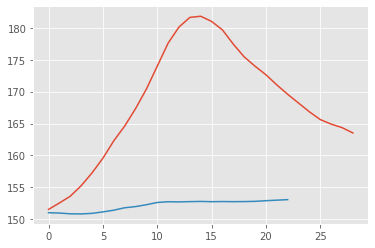

In [39]:
plt.style.use('ggplot')
plt.plot(meal_df_Avg)
plt.plot(no_meal_df_Avg)
plt.show()

0      304.0
1      132.0
2      216.0
3      213.0
4      198.0
       ...  
755    249.0
756    201.0
757    172.0
758    263.0
759    192.0
Length: 760, dtype: float64
0       189.0
1        72.0
2        99.0
3       127.0
4       175.0
        ...  
2715    263.0
2716    195.0
2717    216.0
2718    174.0
2719    169.0
Length: 2720, dtype: float64


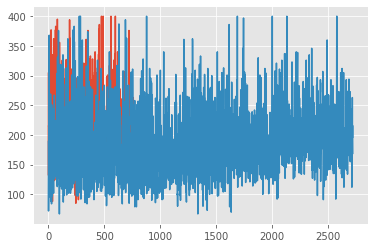

In [40]:
meal_df_MaxCGM = meal_df.iloc[:,0:29].max(axis=1)
print(meal_df_MaxCGM)
no_meal_df_MaxCGM = no_meal_df.iloc[:,0:23].max(axis=1)
print(no_meal_df_MaxCGM)
plt.plot(meal_df_MaxCGM)
plt.plot(no_meal_df_MaxCGM)
plt.show()

In [41]:
# meal_df['Class']=1
meal_df
meal_df

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,Min_ind,Max_ind,Max_Min_inddiff,FFTMAX,FFTMIN,FFTVAR
0,304.0,292.0,281.0,268.0,259.0,255.0,248.0,241.0,231.0,220.0,...,274.0,284.0,283.0,278.0,9,0,-9,7399.0,-109.137202,1.817285e+06
1,40.0,40.0,40.0,40.0,60.0,71.0,83.0,87.0,100.0,112.0,...,67.0,74.0,77.0,81.0,0,13,13,2364.0,-415.302527,1.979984e+05
2,212.0,210.0,204.0,200.0,199.0,201.0,201.0,194.0,188.0,183.0,...,210.0,209.0,210.0,209.0,13,23,10,5710.0,-98.034977,1.084470e+06
3,145.0,141.0,137.0,133.0,129.0,124.0,125.0,122.0,123.0,130.0,...,173.0,165.0,153.0,152.0,7,18,11,4818.0,-343.841414,7.842711e+05
4,40.0,40.0,46.0,53.0,57.0,57.0,55.0,58.0,70.0,77.0,...,183.0,191.0,198.0,200.0,0,29,29,3225.0,-120.527900,3.692766e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
755,146.0,143.0,140.0,135.0,123.0,113.0,109.0,102.0,103.0,117.0,...,226.0,211.0,202.0,192.0,7,22,15,5393.0,-281.467194,9.972095e+05
756,201.0,198.0,198.0,200.0,199.0,200.0,197.0,187.0,175.0,172.0,...,76.0,84.0,96.0,109.0,26,0,-26,4099.0,-653.813673,5.920656e+05
757,159.0,158.0,152.0,153.0,152.0,150.0,147.0,143.0,134.0,132.0,...,153.0,164.0,172.0,179.0,9,29,20,4301.0,-29.420658,6.138344e+05
758,172.0,179.0,186.0,207.0,210.0,216.0,222.0,233.0,248.0,254.0,...,132.0,130.0,120.0,115.0,29,10,-19,5365.0,-844.569969,1.003920e+06


In [42]:
meal_df['Max_CGM'] = meal_df.iloc[:,0:29].max(axis=1)
meal_df['Min_CGM'] = meal_df.iloc[:,0:29].min(axis=1)
meal_df['Mean_CGM'] = meal_df.iloc[:,0:29].mean(axis=1)
meal_df['Max_Min_PCT'] = (meal_df['Max_CGM'] - meal_df['Min_CGM'])/meal_df['Min_CGM']*100
meal_df['Max_Min_Slope'] = (meal_df['Max_CGM'] - meal_df['Min_CGM'])/meal_df['Max_Min_inddiff'].abs()
meal_df['Feature1'] =((meal_df['Max_CGM']-meal_df['Mean_CGM'])*(meal_df['Min_CGM']-meal_df['Mean_CGM']))*((meal_df['Max_CGM']-meal_df['Mean_CGM'])*(meal_df['Min_CGM']-meal_df['Mean_CGM']))/meal_df['Min_CGM']
meal_df

,0,1,2,3,4,5,6,7,8,9,...,Max_Min_inddiff,FFTMAX,FFTMIN,FFTVAR,Max_CGM,Min_CGM,Mean_CGM,Max_Min_PCT,Max_Min_Slope,Feature1
0,304.0,292.0,281.0,268.0,259.0,255.0,248.0,241.0,231.0,220.0,...,-9,7399.0,-109.137202,1.817285e+06,304.0,220.0,255.137931,38.181818,9.333333,13399.031129
1,40.0,40.0,40.0,40.0,60.0,71.0,83.0,87.0,100.0,112.0,...,13,2364.0,-415.302527,1.979984e+05,132.0,40.0,81.517241,230.000000,7.076923,109820.431142
2,212.0,210.0,204.0,200.0,199.0,201.0,201.0,194.0,188.0,183.0,...,10,5710.0,-98.034977,1.084470e+06,216.0,168.0,196.896552,28.571429,4.800000,1813.870566
3,145.0,141.0,137.0,133.0,129.0,124.0,125.0,122.0,123.0,130.0,...,11,4818.0,-343.841414,7.842711e+05,213.0,122.0,166.137931,74.590164,8.272727,35067.679646
4,40.0,40.0,46.0,53.0,57.0,57.0,55.0,58.0,70.0,77.0,...,29,3225.0,-120.527900,3.692766e+05,198.0,40.0,111.206897,395.000000,5.448276,954892.671231
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
755,146.0,143.0,140.0,135.0,123.0,113.0,109.0,102.0,103.0,117.0,...,15,5393.0,-281.467194,9.972095e+05,249.0,102.0,185.965517,144.117647,9.800000,274636.433466
756,201.0,198.0,198.0,200.0,199.0,200.0,197.0,187.0,175.0,172.0,...,-26,4099.0,-653.813673,5.920656e+05,201.0,76.0,141.344828,164.473684,4.807692,199942.469127
757,159.0,158.0,152.0,153.0,152.0,150.0,147.0,143.0,134.0,132.0,...,20,4301.0,-29.420658,6.138344e+05,172.0,132.0,148.310345,30.303030,2.000000,1131.018823
758,172.0,179.0,186.0,207.0,210.0,216.0,222.0,233.0,248.0,254.0,...,-19,5365.0,-844.569969,1.003920e+06,263.0,120.0,185.000000,119.166667,7.526316,214207.500000


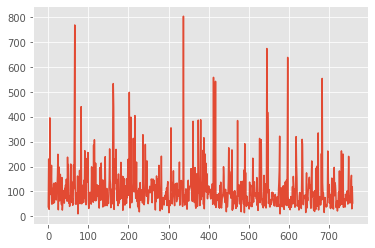

In [43]:
plt.plot(meal_df['Max_Min_PCT'])
# plt.plot(no_meal_df['Max_Min_PCT'])
plt.show()

In [44]:
# no_meal_df['Class']=0
no_meal_df['Max_CGM'] = no_meal_df.iloc[:,0:23].max(axis=1)
no_meal_df['Min_CGM'] = no_meal_df.iloc[:,0:23].min(axis=1)
no_meal_df['Mean_CGM'] = no_meal_df.iloc[:,0:23].mean(axis=1)
no_meal_df['Max_Min_PCT'] = (no_meal_df['Max_CGM'] - no_meal_df['Min_CGM'])/no_meal_df['Min_CGM']*100
no_meal_df['Max_Min_Slope'] = (no_meal_df['Max_CGM'] - no_meal_df['Min_CGM'])/no_meal_df['Max_Min_inddiff'].abs()
no_meal_df['Feature1'] =((no_meal_df['Max_CGM']-no_meal_df['Mean_CGM'])*(no_meal_df['Min_CGM']-no_meal_df['Mean_CGM']))*((no_meal_df['Max_CGM']-no_meal_df['Mean_CGM'])*(no_meal_df['Min_CGM']-no_meal_df['Mean_CGM']))/no_meal_df['Min_CGM']
no_meal_df = no_meal_df.sample(760)
no_meal_df

,0,1,2,3,4,5,6,7,8,9,...,Max_Min_inddiff,FFTMAX,FFTMIN,FFTVAR,Max_CGM,Min_CGM,Mean_CGM,Max_Min_PCT,Max_Min_Slope,Feature1
1901,133.0,131.0,135.0,141.0,138.0,132.0,127.0,124.0,125.0,128.0,...,-11,2882.0,-103.592736,3.468961e+05,141.0,99.0,125.304348,42.424242,3.818182,1721.783789
2417,207.0,210.0,213.0,215.0,213.0,214.0,216.0,217.0,219.0,222.0,...,-12,5000.0,-121.058702,1.044707e+06,229.0,196.0,217.391304,16.836735,2.750000,314.619266
2007,113.0,111.0,107.0,105.0,103.0,102.0,105.0,108.0,111.0,112.0,...,6,2518.0,-37.689427,2.634814e+05,117.0,102.0,109.478261,14.705882,2.500000,31.019699
7,316.0,318.0,321.0,327.0,326.0,328.0,326.0,324.0,327.0,339.0,...,-11,7660.0,-270.749380,2.455269e+06,368.0,292.0,333.043478,26.027397,6.909091,7049.558041
2428,175.0,172.0,170.0,167.0,165.0,164.0,162.0,161.0,160.0,158.0,...,-23,3663.0,-62.905026,5.586140e+05,175.0,152.0,159.260870,15.131579,1.000000,85.920175
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2405,165.0,167.0,168.0,171.0,170.0,164.0,151.0,141.0,134.0,131.0,...,-13,3255.0,-179.595848,4.454405e+05,171.0,126.0,141.521739,35.714286,3.461538,1661.551974
2657,167.0,168.0,168.0,168.0,168.0,169.0,170.0,170.0,171.0,171.0,...,-10,3901.0,-27.339984,6.337240e+05,172.0,164.0,169.608696,4.878049,0.800000,1.096856
2469,130.0,129.0,127.0,125.0,122.0,124.0,130.0,133.0,136.0,134.0,...,-4,2908.0,-29.402758,3.512439e+05,136.0,119.0,126.434783,14.285714,4.250000,42.499055
656,104.0,104.0,103.0,102.0,104.0,104.0,105.0,112.0,114.0,112.0,...,20,2500.0,-20.113722,2.592412e+05,122.0,102.0,108.695652,19.607843,1.000000,77.798779


In [45]:
meal_df['Class']=1
# meal_df = meal_df[['Max_CGM','Min_CGM','Max_Min_PCT','Mean_CGM','Class']]
# meal_df = meal_df[['Mean_CGM','Feature1','Max_Min_PCT','Max_Min_Slope','Class']]
# meal_df = meal_df[['Feature1','Max_Min_Slope','Class']]
# meal_df = meal_df[['Mean_CGM','Feature1','Max_Min_PCT','Class']]
# meal_df = meal_df[['Feature1','Max_Min_PCT','FFTVAR','Class']]
# meal_df = meal_df[['Feature1','Max_Min_PCT','FFTVAR','FFTMAX','FFTMIN','Class']]
meal_df = meal_df[['FFTVAR','FFTMAX','FFTMIN','Class']]

In [46]:
no_meal_df['Class']=0
# no_meal_df = no_meal_df[['Max_CGM','Min_CGM','Max_Min_PCT','Mean_CGM','Class']]
# no_meal_df = no_meal_df[['Mean_CGM','Feature1','Max_Min_PCT','Max_Min_Slope','Class']]
# no_meal_df = no_meal_df[['Feature1','Max_Min_Slope','Class']]
# no_meal_df = no_meal_df[['Mean_CGM','Feature1','Max_Min_PCT','Class']]
# no_meal_df = no_meal_df[['Feature1','Max_Min_PCT','FFTVAR','Class']]
# no_meal_df = no_meal_df[['Feature1','Max_Min_PCT','FFTVAR','FFTMAX','FFTMIN','Class']]
no_meal_df = no_meal_df[['FFTVAR','FFTMAX','FFTMIN','Class']]

In [47]:
final_df = pd.concat([meal_df,no_meal_df], ignore_index=True, sort=False)
final_df
# final_df.drop(columns=['Mean_CGM','Max_Min_PCT'],inplace=True)
final_df

,FFTVAR,FFTMAX,FFTMIN,Class
0,1.817285e+06,7399.0,-109.137202,1
1,1.979984e+05,2364.0,-415.302527,1
2,1.084470e+06,5710.0,-98.034977,1
3,7.842711e+05,4818.0,-343.841414,1
4,3.692766e+05,3225.0,-120.527900,1
...,...,...,...,...
1515,4.454405e+05,3255.0,-179.595848,0
1516,6.337240e+05,3901.0,-27.339984,0
1517,3.512439e+05,2908.0,-29.402758,0
1518,2.592412e+05,2500.0,-20.113722,0


In [84]:
X = np.array(final_df.drop(['Class'],1))
X = preprocessing.scale(X)
y = np.array(final_df['Class'])

In [85]:
kf = RepeatedKFold(n_splits=5, n_repeats=5)

In [96]:
# #Decision tree
for X_train, X_test in kf.split(X):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2)

#     clf = tree.DecisionTreeClassifier()
#     clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth = 8)
#     clf = tree.DecisionTreeClassifier(criterion='gini', max_depth =8)
    clf = tree.DecisionTreeClassifier(random_state=0, max_depth =8)

    clf.fit(X_train, y_train)
    predicted_set = clf.predict(X_test)
    confusion_matrix(y_test, predicted_set)
    classification_report(y_test, predicted_set)


    accuracy = int(accuracy_score(y_test, predicted_set)*100)
#     print(accuracy)
    print(classification_report(y_test,predicted_set))
#     print(confusion_matrix(y_test,predicted_set))
#     filename =str(accuracy)+'_decision_tree.pkl'
#     pickle.dump(clf, open(filename,'wb'))

[[122  20]
 [  2 160]]
              precision    recall  f1-score   support

           0       0.98      0.86      0.92       142
           1       0.89      0.99      0.94       162

    accuracy                           0.93       304
   macro avg       0.94      0.92      0.93       304
weighted avg       0.93      0.93      0.93       304

[[139  15]
 [  9 141]]
              precision    recall  f1-score   support

           0       0.94      0.90      0.92       154
           1       0.90      0.94      0.92       150

    accuracy                           0.92       304
   macro avg       0.92      0.92      0.92       304
weighted avg       0.92      0.92      0.92       304

[[146  12]
 [  8 138]]
              precision    recall  f1-score   support

           0       0.95      0.92      0.94       158
           1       0.92      0.95      0.93       146

    accuracy                           0.93       304
   macro avg       0.93      0.93      0.93       304
weigh

In [51]:
# tree.plot_tree(clf) 

In [98]:
# SVM
for X_train, X_test in kf.split(X):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2)

    clf = svm.SVC(kernel='rbf',gamma='scale',C=1)
#     clf = svm.SVC(kernel='rbf',gamma=0.00001,C=100)
#     clf = svm.SVC(kernel='sigmoid')
#     clf = svm.SVC(kernel='poly', degree=8)
#     clf = svm.SVC(kernel='poly', degree=3,gamma='auto')
    clf.fit(X_train, y_train)
    predicted_set = clf.predict(X_test)
    confusion_matrix(y_test, predicted_set)
    classification_report(y_test, predicted_set)
    
    
    print(confusion_matrix(y_test, predicted_set))
    accuracy = int(accuracy_score(y_test, predicted_set)*100)
    print(accuracy)
    print(classification_report(y_test,predicted_set))
#     filename =str(accuracy)+'_SVM.pkl'
#     pickle.dump(clf, open(filename,'wb'))

[[147   3]
 [  2 152]]
98
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       150
           1       0.98      0.99      0.98       154

    accuracy                           0.98       304
   macro avg       0.98      0.98      0.98       304
weighted avg       0.98      0.98      0.98       304

[[145   2]
 [  4 153]]
98
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       147
           1       0.99      0.97      0.98       157

    accuracy                           0.98       304
   macro avg       0.98      0.98      0.98       304
weighted avg       0.98      0.98      0.98       304

[[151   5]
 [  2 146]]
97
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       156
           1       0.97      0.99      0.98       148

    accuracy                           0.98       304
   macro avg       0.98      0.98      0.98       

In [53]:
# #knn
# for X_train, X_test in kf.split(X):
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2)
#     clf = KNeighborsClassifier(n_neighbors=10,p=2)
#     clf.fit(X_train, y_train)
#     predicted_set = clf.predict(X_test)
#     accuracy = int(accuracy_score(y_test, predicted_set)*100)
# #     print(classification_report(y_test, predicted_set))
# #     print(confusion_matrix(y_test, predicted_set))
#     print(accuracy)
#     filename =str(accuracy)+'_knn.pkl'
#     pickle.dump(clf, open(filename,'wb'))

In [54]:
# MLP
# for X_train, X_test in kf.split(X):
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2)
#     clf = MLPClassifier(alpha=1,max_iter=1000)
#     clf.fit(X_train, y_train)
#     predicted_set = clf.predict(X_test)
#     accuracy = int(accuracy_score(y_test, predicted_set)*100)
# #     print(classification_report(y_test, predicted_set))
# #     print(confusion_matrix(y_test, predicted_set))
#     print(accuracy)
# #     filename =str(accuracy)+'_mlp.pkl'
# #     pickle.dump(clf, open(filename,'wb'))

In [55]:
# # RandomForest
# for X_train, X_test in kf.split(X):
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2)
#     clf = RandomForestClassifier(n_estimators=100,max_depth=4,max_features=3)
#     clf.fit(X_train, y_train)
#     predicted_set = clf.predict(X_test)
#     accuracy = int(accuracy_score(y_test, predicted_set)*100)
# # # #     print(classification_report(y_test, predicted_set))
# # # #     print(confusion_matrix(y_test, predicted_set))
#     print(accuracy)
# # #     filename =str(accuracy)+'_rforest.pkl'
# # #     pickle.dump(clf, open(filename,'wb'))

In [56]:
# # Adaboost
# for X_train, X_test in kf.split(X):
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2)
#     clf = AdaBoostClassifier(n_estimators=10,random_state=0)
#     clf.fit(X_train, y_train)
#     predicted_set = clf.predict(X_test)
#     accuracy = int(accuracy_score(y_test, predicted_set)*100)
# # # #     print(classification_report(y_test, predicted_set))
# # # #     print(confusion_matrix(y_test, predicted_set))
#     print(accuracy)
# # #     filename =str(accuracy)+'_adaboost.pkl'
# # #     pickle.dump(clf, open(filename,'wb'))